### Predicting Renewals with Anthem's Policyholder Dataset

In [30]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("Anthem_Mini_Project.csv")

### Exploratory Data Analysis

In [3]:
data.columns

Index(['RTD_ST_CD', 'CustomerSegment', 'Tenure', 'Age', 'MART_STATUS',
       'GENDER', 'CHANNEL1_6M', 'CHANNEL2_6M', 'CHANNEL3_6M', 'CHANNEL4_6M',
       'CHANNEL5_6M', 'METHOD1_6M', 'RECENT_PAYMENT', 'PAYMENTS_6M',
       'CHANNEL1_3M', 'CHANNEL2_3M', 'CHANNEL3_3M', 'CHANNEL4_3M',
       'CHANNEL5_3M', 'METHOD1_3M', 'PAYMENTS_3M', 'LATE_PAYMENT_3M',
       'LATE_PAYMENT_6M', 'EVENT1_30_FLAG', 'EVENT2_90_SUM', 'LOGINS',
       'POLICYPURCHASECHANNEL', 'Call_Flag'],
      dtype='object')

In [4]:
len(data)

130086

It looks like we have columns for the following information:

- state code

- customer segmentation

- length of time of being a policyholder with Anthem

- age

- marital status

- gender

- number of times a policyholder has contacted Anthem through channel 1 in the past 6 months

- number of times a policyholder has contacted Anthem through channel 2 in the past 6 months

- number of times a policyholder has contacted Anthem through channel 3 in the past 6 months

- number of times a policyholder has contacted Anthem through channel 4 in the past 6 months

- number of times a policyholder has contacted Anthem through channel 5 in the past 6 months

- number of times a policyholder has made premium payments with method 1 in the past 6 months

- an indicator for whether the policyholder has made a recent policy payment in the past 10 days

- number of premium payments made in the past 6 months

- number of times a policyholder has contacted Anthem through channel 1 in the past 3 months

- number of times a policyholder has contacted Anthem through channel 2 in the past 3 months

- number of times a policyholder has contacted Anthem through channel 3 in the past 3 months

- number of times a policyholder has contacted Anthem through channel 4 in the past 3 months

- number of times a policyholder has contacted Anthem through channel 5 in the past 3 months

- number of times a policyholder has made premium payments with method 1 in the past 3 months

- number of premium payments made in the past 3 months

- an indicator for whether the policyholder has made a late payment in the past 3 months

- an indicator for whether the policyholder has made a late payment in the past 6 months

- an indicator for whether "Event 1" happened in the past 30 days

- number of times "Event 2" happened in the past 90 days

- number of times the policyholder has logged into his/her Anthem account

- channel the policyholder used to purchase his/her policy (e.g., online chat, email, mail, phone)

- an indicator (i.e., **target variable**) for whether the customer calls to renew his/her policy

Things we can potentially do with this data (before analysis) to gain insights for the business:

- allocate resources from unused channels toward more-frequently used channels

- increase or lower payment interval schedules to optimize for the probability of policyholder renewal

- explore whether late-payment forgiveness could lead to increased customer satisfaction and loyalty (i.e., renewal)

- redesign the Anthem policyholder website to be more user-friendly

- have Anthem prioritize improving certain channels over others

- increase marketing efforts and special promotions for certain states

#### Summary statistics for select individual columns

In [5]:
data.RTD_ST_CD.describe()

count     130086
unique        51
top        ST_S7
freq       24475
Name: RTD_ST_CD, dtype: object

State 51 might correspond to Puerto Rico.

In [6]:
data.Tenure.describe()

count    130086.000000
mean          8.583048
std           7.297112
min           0.032854
25%           3.249829
50%           7.006160
75%          11.610540
max          63.091034
Name: Tenure, dtype: float64

Mean policy age is around 8.5 years, with 3.2 years and 11.6 years as the 25th and 75th percentiles.

In [7]:
data.Age.describe()

count    130086.000000
mean         48.842201
std          14.038089
min          16.689938
25%          37.878166
50%          49.147159
75%          58.858316
max          99.348392
Name: Age, dtype: float64

Mean policyholder age is 48.8 years, with a minimum age of 16.6, maximum age of 99.3, and 37.8 years and 58.8 years as the 25th and 75th percentiles.

In [8]:
np.sum(data.LATE_PAYMENT_3M) / len(data.LATE_PAYMENT_3M)

0.05567086389004197

5.5% of policyholders had at least 1 late payment within the past 3 months

In [9]:
np.sum(data.LATE_PAYMENT_6M) / len(data.LATE_PAYMENT_6M)

0.08000860968897498

8% of policyholders had at least 1 late payment within the past 6 months

In [10]:
np.sum(data.Call_Flag) / len(data.Call_Flag)

0.036621927032885936

Interesting finding: only 3.6% of all policyholders in the dataset contacted Anthem to renew their policies. I might have to upweight the minority class (i.e., renewals) if I am to construct a model that can accurately predict renewal probability.

#### Plotting distributions (i.e., histograms) for select individual columns

(array([21032., 49345., 16316.,  5866., 11532.,  4709.,  5431.,  5128.,
         8626.,  2101.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

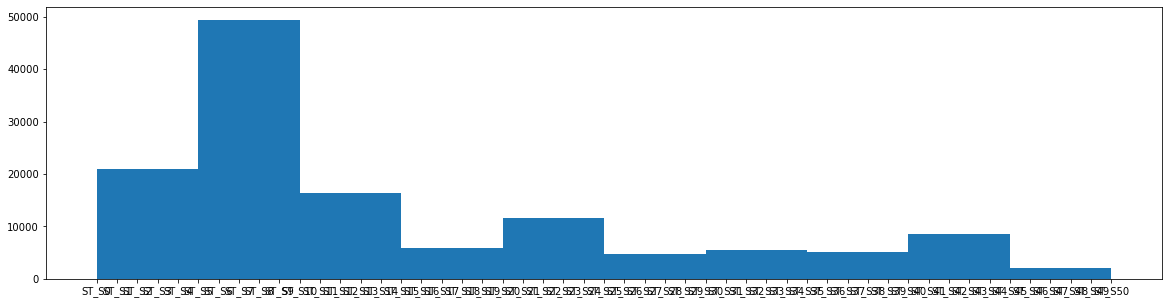

In [11]:
plt.figure(figsize=(20,5))
plt.hist(data.RTD_ST_CD)

States with the first quartile of ordered labels seem to be overrepresented in the dataset.

(array([5.8491e+04, 4.2532e+04, 1.8891e+04, 5.5200e+03, 2.4310e+03,
        8.0200e+02, 1.3700e+03, 2.5000e+01, 2.2000e+01, 2.0000e+00]),
 array([3.2854000e-02, 6.3386720e+00, 1.2644490e+01, 1.8950308e+01,
        2.5256126e+01, 3.1561944e+01, 3.7867762e+01, 4.4173580e+01,
        5.0479398e+01, 5.6785216e+01, 6.3091034e+01]),
 <a list of 10 Patch objects>)

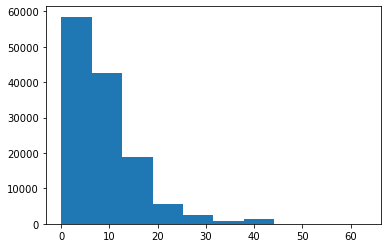

In [12]:
plt.hist(data.Tenure)

(array([ 4349., 16620., 21001., 25062., 27952., 20424., 10375.,  3419.,
          797.,    87.]),
 array([16.689938 , 24.9557834, 33.2216288, 41.4874742, 49.7533196,
        58.019165 , 66.2850104, 74.5508558, 82.8167012, 91.0825466,
        99.348392 ]),
 <a list of 10 Patch objects>)

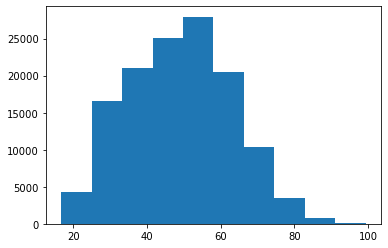

In [13]:
plt.hist(data.Age)

(array([ 4853.,     0., 45717.,     0.,     0., 58164.,     0., 13446.,
            0.,  7906.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

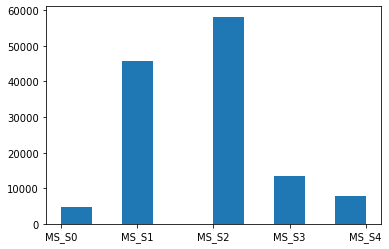

In [14]:
plt.hist(data.MART_STATUS)

(array([60177.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 69909.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

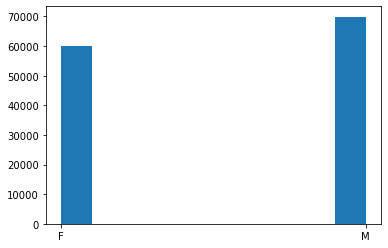

In [15]:
plt.hist(data.GENDER)

#### Heatmap / correlation plot (with call_flag, i.e., whether the policyholder calls to renew, as the target variable)

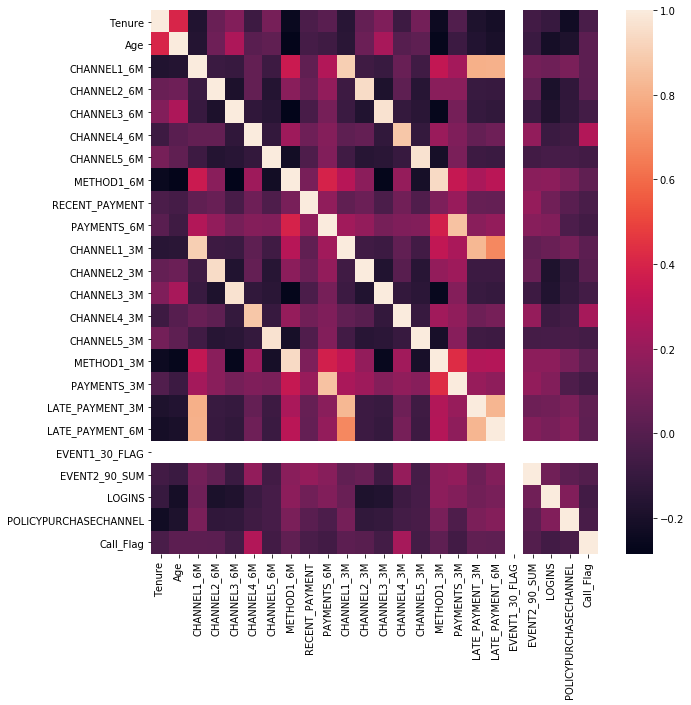

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())

It looks like "CHANNEL4_6M" and "CHANNEL4_3M" are moderately correlated with a chance of policy renewal.

### Data Engineering

In [17]:
data

,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,LATE_PAYMENT_3M,LATE_PAYMENT_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,ST_S0,1,16.175222,78.403833,MS_S0,F,0.0,0.0,1.0,0.0,...,2,0,3,0,0,0,0,0,0,0
1,ST_S0,1,15.931554,70.989733,MS_S1,F,0.0,6.0,0.0,0.0,...,0,3,3,0,0,0,0,0,0,0
2,ST_S0,1,15.937029,87.578371,MS_S2,M,0.0,0.0,10.0,0.0,...,0,0,6,0,0,0,0,0,0,0
3,ST_S1,1,15.934292,68.438056,MS_S2,M,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,ST_S0,1,15.501711,80.514716,MS_S0,F,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130081,ST_S16,NONE,0.131417,46.258727,MS_S2,M,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
130082,ST_S41,NONE,0.117728,36.574949,MS_S1,M,0.0,0.0,0.0,0.0,...,0,0,2,0,0,0,0,0,0,0
130083,ST_S14,NONE,0.131417,56.906229,MS_S3,M,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
130084,ST_S14,NONE,0.087611,23.857632,MS_S2,M,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [18]:
np.sum(data.isnull())

RTD_ST_CD                  0
CustomerSegment            0
Tenure                     0
Age                        0
MART_STATUS                0
GENDER                     0
CHANNEL1_6M              809
CHANNEL2_6M              809
CHANNEL3_6M              809
CHANNEL4_6M              809
CHANNEL5_6M              809
METHOD1_6M               809
RECENT_PAYMENT           809
PAYMENTS_6M              809
CHANNEL1_3M                0
CHANNEL2_3M                0
CHANNEL3_3M                0
CHANNEL4_3M                0
CHANNEL5_3M                0
METHOD1_3M                 0
PAYMENTS_3M                0
LATE_PAYMENT_3M            0
LATE_PAYMENT_6M            0
EVENT1_30_FLAG             0
EVENT2_90_SUM              0
LOGINS                     0
POLICYPURCHASECHANNEL      0
Call_Flag                  0
dtype: int64

#### Median value imputation

In [19]:
c1_6m = np.median(data.CHANNEL1_6M)
data.CHANNEL1_6M = data.CHANNEL1_6M.fillna(c1_6m)

c2_6m = np.median(data.CHANNEL2_6M)
data.CHANNEL2_6M = data.CHANNEL2_6M.fillna(c2_6m)

c3_6m = np.median(data.CHANNEL3_6M)
data.CHANNEL3_6M = data.CHANNEL3_6M.fillna(c3_6m)

c4_6m = np.median(data.CHANNEL4_6M)
data.CHANNEL4_6M = data.CHANNEL4_6M.fillna(c4_6m)

c5_6m = np.median(data.CHANNEL5_6M)
data.CHANNEL5_6M = data.CHANNEL5_6M.fillna(c5_6m)

m1_6m = np.median(data.METHOD1_6M)
data.METHOD1_6M = data.METHOD1_6M.fillna(m1_6m)

recent_payment = np.median(data.RECENT_PAYMENT)
data.RECENT_PAYMENT = data.RECENT_PAYMENT.fillna(recent_payment)

payments_6m = np.median(data.PAYMENTS_6M)
data.PAYMENTS_6M = data.PAYMENTS_6M.fillna(payments_6m)

#### One-hot encoding

In [20]:
data.dtypes

RTD_ST_CD                 object
CustomerSegment           object
Tenure                   float64
Age                      float64
MART_STATUS               object
GENDER                    object
CHANNEL1_6M              float64
CHANNEL2_6M              float64
CHANNEL3_6M              float64
CHANNEL4_6M              float64
CHANNEL5_6M              float64
METHOD1_6M               float64
RECENT_PAYMENT           float64
PAYMENTS_6M              float64
CHANNEL1_3M                int64
CHANNEL2_3M                int64
CHANNEL3_3M                int64
CHANNEL4_3M                int64
CHANNEL5_3M                int64
METHOD1_3M                 int64
PAYMENTS_3M                int64
LATE_PAYMENT_3M            int64
LATE_PAYMENT_6M            int64
EVENT1_30_FLAG             int64
EVENT2_90_SUM              int64
LOGINS                     int64
POLICYPURCHASECHANNEL      int64
Call_Flag                  int64
dtype: object

In [21]:
states = pd.get_dummies(data.RTD_ST_CD)

segments = pd.get_dummies(data.CustomerSegment, prefix="Segment")

marital_statuses = pd.get_dummies(data.MART_STATUS)

genders = pd.get_dummies(data.GENDER)

In [22]:
data = data.drop(columns = ["RTD_ST_CD", "CustomerSegment", "MART_STATUS", "GENDER"])

In [23]:
data = pd.concat([data, states], axis=1)
data = pd.concat([data, segments], axis=1)
data = pd.concat([data, marital_statuses], axis=1)
data = pd.concat([data, genders], axis=1)

In [24]:
data.columns

Index(['Tenure', 'Age', 'CHANNEL1_6M', 'CHANNEL2_6M', 'CHANNEL3_6M',
       'CHANNEL4_6M', 'CHANNEL5_6M', 'METHOD1_6M', 'RECENT_PAYMENT',
       'PAYMENTS_6M', 'CHANNEL1_3M', 'CHANNEL2_3M', 'CHANNEL3_3M',
       'CHANNEL4_3M', 'CHANNEL5_3M', 'METHOD1_3M', 'PAYMENTS_3M',
       'LATE_PAYMENT_3M', 'LATE_PAYMENT_6M', 'EVENT1_30_FLAG', 'EVENT2_90_SUM',
       'LOGINS', 'POLICYPURCHASECHANNEL', 'Call_Flag', 'ST_S0', 'ST_S1',
       'ST_S10', 'ST_S11', 'ST_S12', 'ST_S13', 'ST_S14', 'ST_S15', 'ST_S16',
       'ST_S17', 'ST_S18', 'ST_S19', 'ST_S2', 'ST_S20', 'ST_S21', 'ST_S22',
       'ST_S23', 'ST_S24', 'ST_S25', 'ST_S26', 'ST_S27', 'ST_S28', 'ST_S29',
       'ST_S3', 'ST_S30', 'ST_S31', 'ST_S32', 'ST_S33', 'ST_S34', 'ST_S35',
       'ST_S36', 'ST_S37', 'ST_S38', 'ST_S39', 'ST_S4', 'ST_S40', 'ST_S41',
       'ST_S42', 'ST_S43', 'ST_S44', 'ST_S45', 'ST_S46', 'ST_S47', 'ST_S48',
       'ST_S49', 'ST_S5', 'ST_S50', 'ST_S6', 'ST_S7', 'ST_S8', 'ST_S9',
       'Segment_1', 'Segment_2', 'Segment_3',

#### Test-validation-train split

In [25]:
X = data.drop(columns = ["Call_Flag"])
y = data.Call_Flag

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=10)

In [27]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

#### Modeling (XGBoost)

In [28]:
scale_pos_weight = (len(data.Call_Flag) - sum(data.Call_Flag))/sum(data.Call_Flag)

In [29]:
model = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 100000, max_depth = 10, colsample_bynode = 0.7, scale_pos_weight = scale_pos_weight)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.22368
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.20271
[2]	validation_0-error:0.18915
[3]	validation_0-error:0.18044
[4]	validation_0-error:0.17732
[5]	validation_0-error:0.17355
[6]	validation_0-error:0.17131
[7]	validation_0-error:0.16963
[8]	validation_0-error:0.16651
[9]	validation_0-error:0.16516
[10]	validation_0-error:0.16502
[11]	validation_0-error:0.16260
[12]	validation_0-error:0.16167
[13]	validation_0-error:0.16013
[14]	validation_0-error:0.15948
[15]	validation_0-error:0.15892
[16]	validation_0-error:0.15552
[17]	validation_0-error:0.15580
[18]	validation_0-error:0.15580
[19]	validation_0-error:0.15398
[20]	validation_0-error:0.15333
[21]	validation_0-error:0.15230
[22]	validation_0-error:0.14974
[23]	validation_0-error:0.14979
[24]	validation_0-error:0.14993
[25]	validation_0-error:0.14923
[26]	validation_0-error:0.14797
[27]	validation_0-error:0.14704
[28]	validation_0-error:0.14685
[29]	validation_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=0.7, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=26.306045340050378, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [31]:
predictions = np.round(model.predict(X_test))

In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     20702
           1       0.24      0.17      0.20       763

    accuracy                           0.95     21465
   macro avg       0.61      0.58      0.59     21465
weighted avg       0.94      0.95      0.95     21465

